In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression 
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import seaborn as sns
from matplotlib.pyplot import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
from sklearn.ensemble import RandomForestRegressor
import pickle
import math
from sklearn.metrics import mean_squared_log_error

In [2]:
#orig_df = pd.read_csv("../../data/hour.csv")
df = pd.read_csv("../../data/hour.csv")
df.columns = ['Instant','Date','Season','Year','Month','Hour','Holiday','Weekday','Workingday','Weather_Condition','Normalized_Temperature','Normalized_Feels_Temperture','Humidity','Windspeed','Casual','Registered','Demand']
df['Date'] = pd.to_datetime(df['Date'])
df['Date'] += pd.to_timedelta(df['Hour'], unit='h')
df.index = df['Date']
del df['Date']
del df['Instant']
sns.set_style("whitegrid")

In [3]:
df.head()

,Season,Year,Month,Hour,Holiday,Weekday,Workingday,Weather_Condition,Normalized_Temperature,Normalized_Feels_Temperture,Humidity,Windspeed,Casual,Registered,Demand
Date,,,,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
2011-01-01 01:00:00,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2011-01-01 02:00:00,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
2011-01-01 03:00:00,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
2011-01-01 04:00:00,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


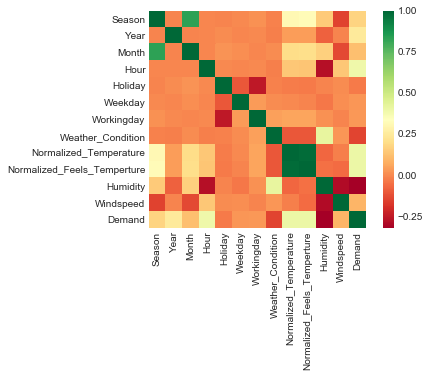

In [4]:
sns.heatmap(df.drop(['Registered','Casual'],axis=1).corr(), square=True, cmap='RdYlGn')
_ = plt.rcParams['figure.figsize'] = [20, 15]
savefig('../../plot/img/correlation_matrix.png', bbox_inches='tight')
plt.show()

In [5]:
labels = 'Demand'

# Linear Regression

In [6]:
def linearRegression(df,features):
    #X = df.drop(['cnt','casual','registered'],axis=1).values
    X = features.values
    y = df[labels].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

    # Create the regressor: reg_all
    reg_all = LinearRegression()
    
    # Fit the regressor to the training data
    reg_all.fit(X_train,y_train)
    
    # Predict on the test data: y_pred
    y_pred = reg_all.predict(X_test)
    
   
    
    #print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test,y_pred))))
    print("R^2: {}".format(reg_all.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    
    
     # Compute and print R^2 and RMSE
    _ = plt.scatter(y_pred,y_test)
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    _ = plt.title('Linear Regression Fitted Plot')
    savefig('../../plot/img/linearregression_fitted_plot.png', bbox_inches='tight')
    plt.show()
    
    reg_coef = reg_all.coef_
    
    _ = plt.plot(range(len(features.columns)),reg_coef)
    _ = plt.xticks(range(len(features.columns)),features,rotation=60)
    _ = plt.ylabel('Coefficients')
    _ = plt.title('Coefficients Linear Regression')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    savefig('../../plot/img/linear_regression.png', bbox_inches='tight')
    _ = plt.show()
    
    residuals = [y_test[i]-y_pred[i] for i in range(len(y_pred))]
    residuals = pd.DataFrame(residuals)
    # plot residuals
    residuals.plot()
    _ = plt.title('Residual Plot Linear Regression')
    savefig('../../plot/img/linear_regression_residual_plot.png', bbox_inches='tight')
    plt.show()


# Cross Validation

In [7]:
def crossValScore(reg,val):
    X = features.values
    y = df[labels].values
    cv_scores = cross_val_score(reg,X,y,cv=val)
    print("Average "+str(val)+"-Fold CV Score: {}".format(np.mean(cv_scores)))

In [8]:
#orig_df.head()

R^2: 0.382043223648
Root Mean Squared Error: 142.758384508


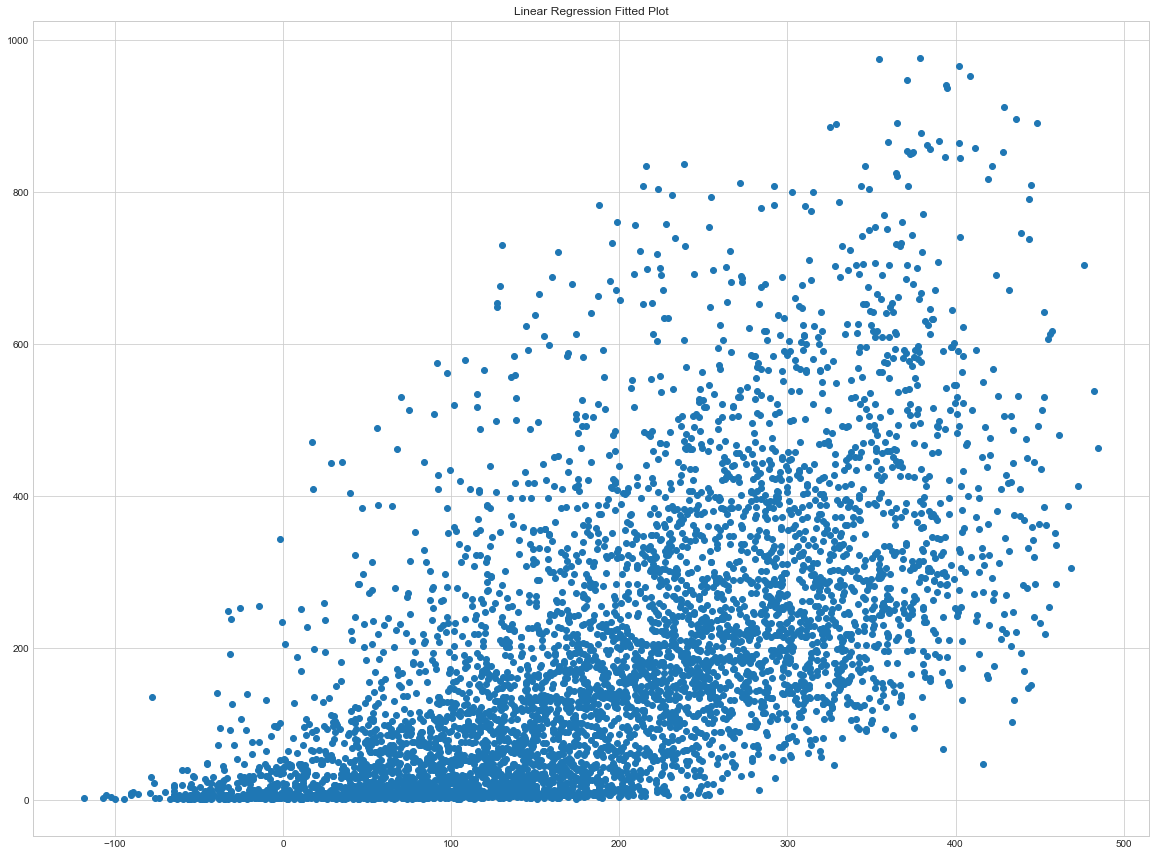

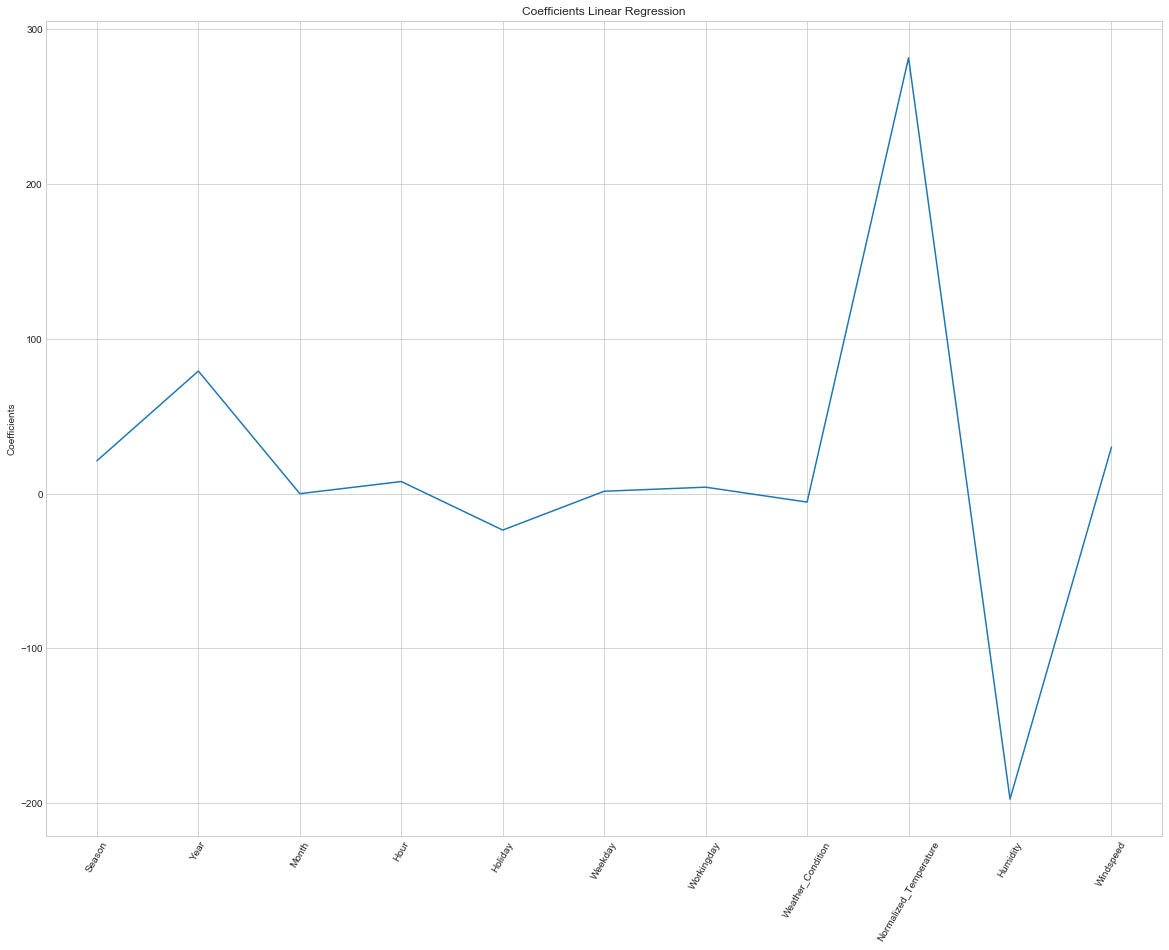

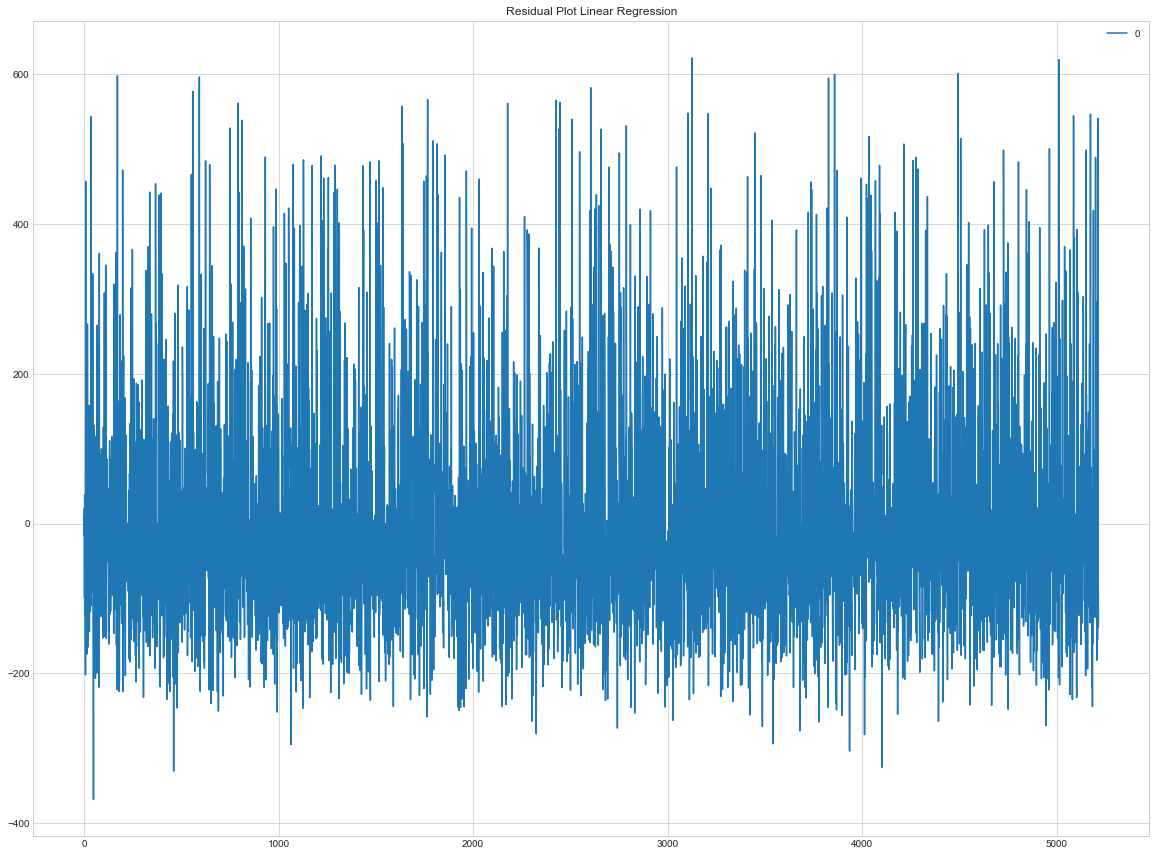

In [9]:

features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
linearRegression(df,features)

In [10]:
reg = LinearRegression()
crossValScore(reg,10)

Average 10-Fold CV Score: 0.159502076739


# Linear Regression With Dummy Variables

R^2: 0.377298718331
Root Mean Squared Error: 142.304056407


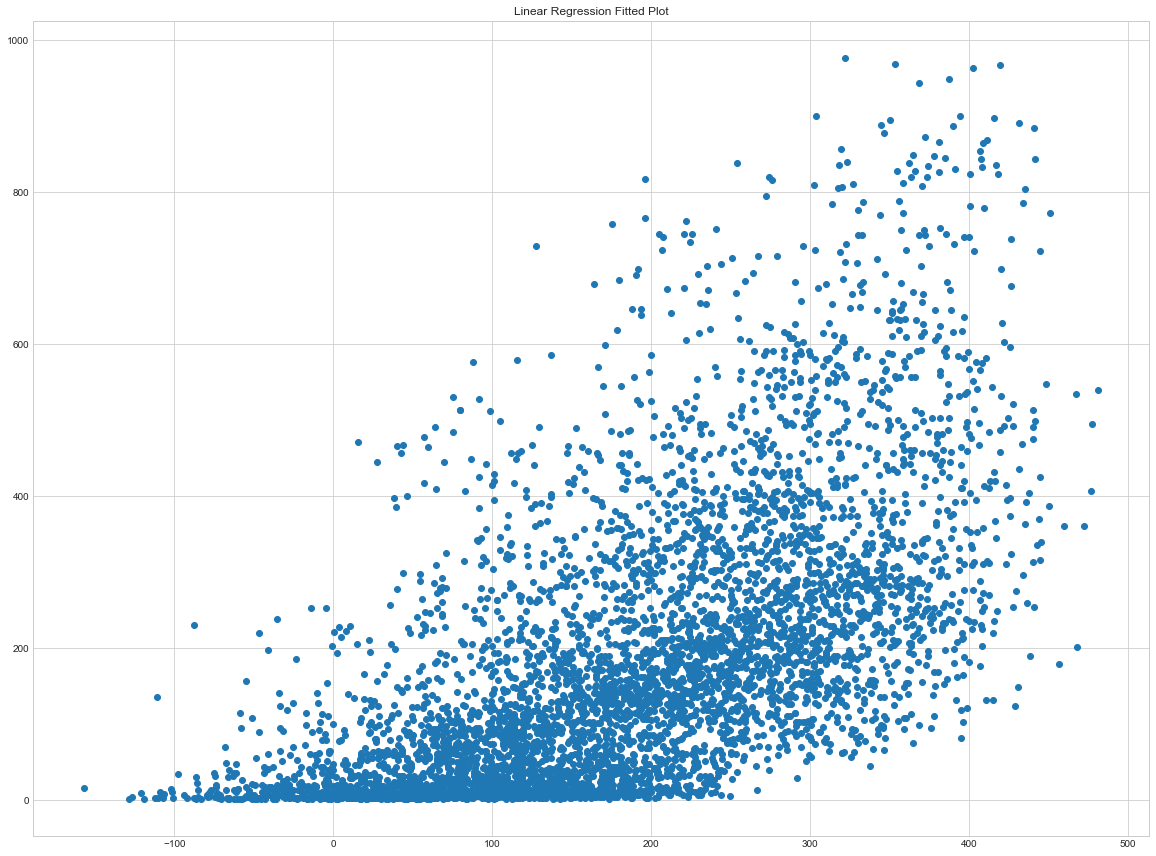

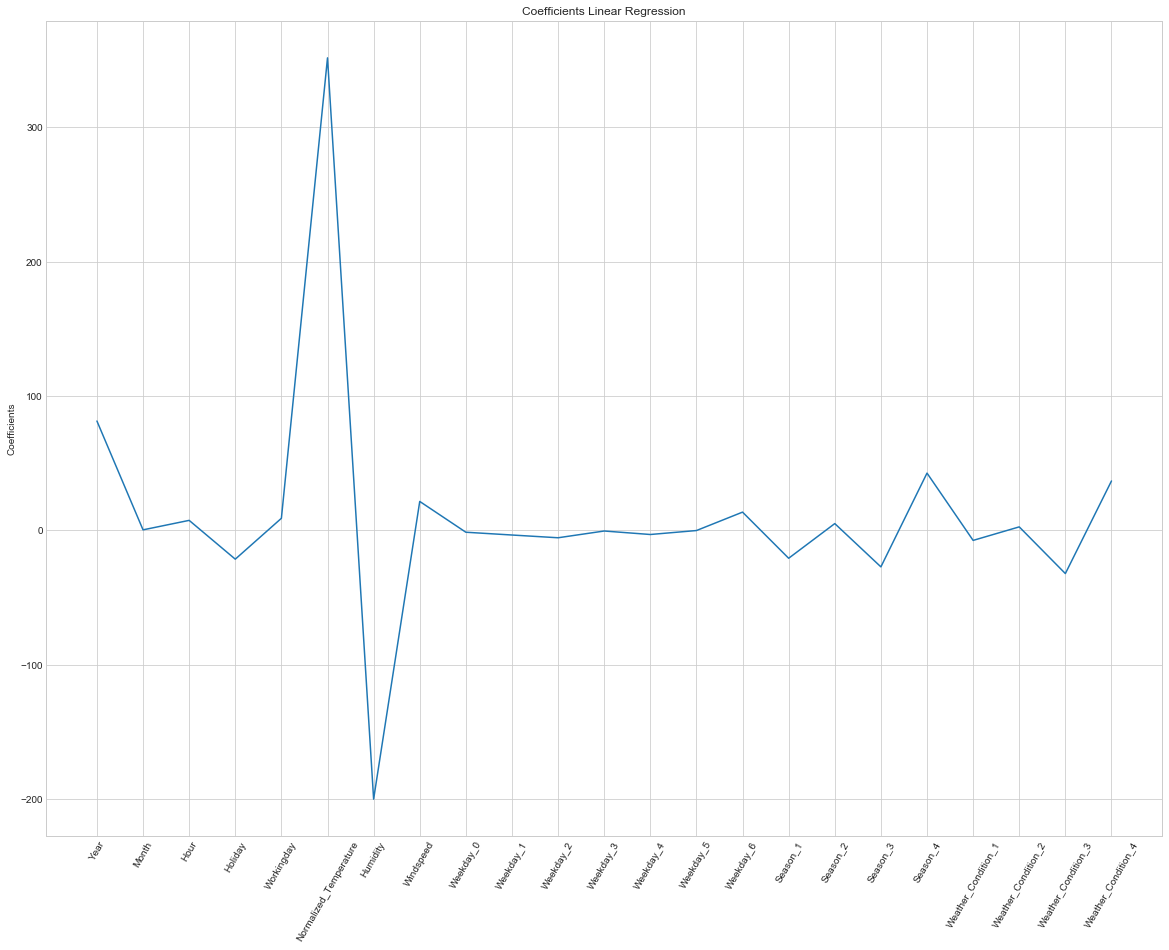

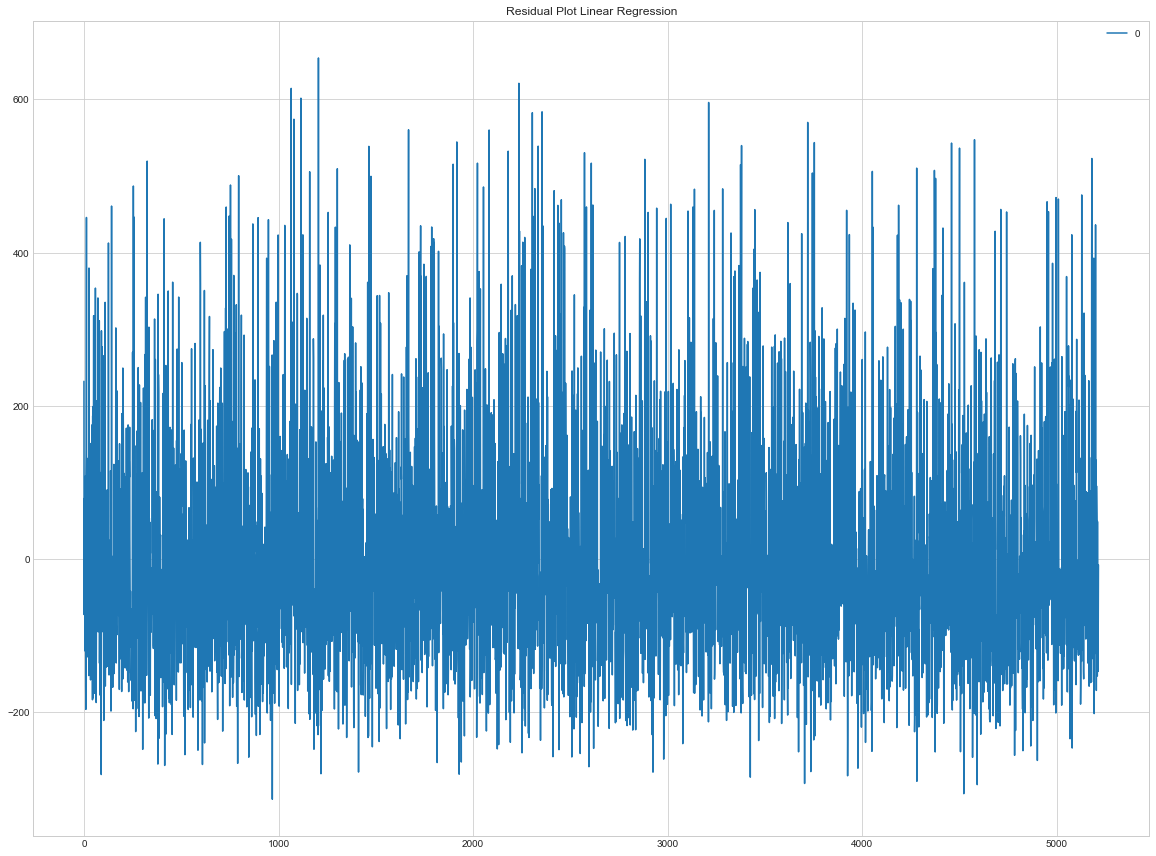

In [11]:
dum_df = pd.get_dummies(df, columns=["Weekday","Season","Weather_Condition"])
features = dum_df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
linearRegression(dum_df,features)

# Lasso Regressor

In [12]:
def lassoTest(df,features):
    X = features.values
    y = df[labels].values
    lasso = Lasso(alpha=0.1)
    lasso_coef = lasso.fit(X,y).coef_
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
    # Predict on the test data: y_pred
    y_pred = lasso.predict(X_test)
    
    _ = plt.scatter(y_pred,y_test)
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    _ = plt.title('Fitted plot Lasso Regression')
    savefig('../../plot/img/lassoregression_fitted_plot.png', bbox_inches='tight')
    plt.show()

    # Compute and print R^2 and RMSE
    print("R^2: {}".format(lasso.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    
    _ = plt.plot(range(len(features.columns)),lasso_coef)
    _ = plt.title('Coefficients Lasso Regression')
    _ = plt.xticks(range(len(features.columns)),features.columns,rotation=60)
    _ = plt.ylabel('Coefficients')

In [13]:
#features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture','Date'],axis=1)
#lassoTest(df,features)

In [14]:
reg = Lasso()
crossValScore(reg,10)

Average 10-Fold CV Score: 0.185555018168


# Ridge Regressor

In [15]:
def ridgeRegression(df,features):
    X = features.values
    y = df[labels].values
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
    ridge = Ridge(alpha=0.1, normalize=True)
    ridge_coef = ridge.fit(X,y).coef_
    ridge_fit = ridge.fit(X_train,y_train)
    y_pred = ridge.predict(X_test)
    
    _ = plt.scatter(y_pred,y_test)
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    _ = plt.title('Fitted Plot Ridge Tree')
    savefig('../../plot/img/ridgeregression_fitted_plot.png', bbox_inches='tight')
    plt.show()
    
    #print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test,y_pred))))
    
    print("R^2: {}".format(ridge.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    

    _ = plt.plot(range(len(features.columns)),ridge_coef)
    _ = plt.xticks(range(len(features.columns)),features.columns,rotation=60)
    _ = plt.title('Coefficients Ridge Tree')
    _ = plt.ylabel('Coefficients')
    #_ = plt.rcParams['figure.figsize'] = [10, 8]
    savefig('../../plot/img/rigid_regression.png', bbox_inches='tight')
    _ = plt.show()

In [16]:
#features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture','Date'],axis=1)
#ridgeRegression(df,features)

<h1>Decision Tree - Randomized Search CV</h1>

In [17]:
def decisionTreeRegressionOptimizer(df):
    
    df = df.sample(frac=1)
    features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
    X = features.values
    y = np.log(df[labels]).values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
    
    base_model = DecisionTreeRegressor(random_state = 42,max_depth=30)
    base_model.fit(X_train, y_train)
    
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 50, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 3, 5]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2]
    # Create the random grid
    random_grid = {'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf}
    
    regr = DecisionTreeRegressor()
    
    reg_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    reg_random.fit(X_train, y_train)
    
    pprint(reg_random.best_params_)
    
    best_random = reg_random.best_estimator_
    
    print("R^2 Base : {}".format(base_model.score(X_test, y_test)))
    print("R^2 Randomized Search Cross Validation: {}".format(best_random.score(X_test, y_test)))
    

In [18]:
decisionTreeRegressionOptimizer(df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2 
[CV]  min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2, total=   0.0s
[CV] min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2 
[CV] min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2 
[CV]  min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2, total=   0.0s
[CV] min_samples_split=5, max_features=auto, max_depth=50, min_samples_leaf=1 
[CV]  min_samples_split=3, max_features=auto, max_depth=1, min_samples_leaf=2, total=   0.0s
[CV] min_samples_split=5, max_features=auto, max_depth=50, min_samples_leaf=1 
[CV] min_samples_split=5, max_features=auto, max_depth=50, min_samples_leaf=1 
[CV] min_samples_split=2, max_features=auto, max_depth=15, min_samples_leaf=1 
[CV]  min_samples_split=5, max_features=auto, max_depth=50, min_samples_leaf=1, total=   0.0s
[CV]  min_sample

[Parallel(n_jobs=-1)]: Done  14 out of  60 | elapsed:    0.3s remaining:    0.9s


[CV]  min_samples_split=2, max_features=auto, max_depth=45, min_samples_leaf=1, total=   0.1s
[CV]  min_samples_split=3, max_features=auto, max_depth=15, min_samples_leaf=2, total=   0.0s
[CV] min_samples_split=3, max_features=auto, max_depth=15, min_samples_leaf=2 
[CV] min_samples_split=2, max_features=auto, max_depth=45, min_samples_leaf=1 
[CV]  min_samples_split=2, max_features=auto, max_depth=30, min_samples_leaf=2, total=   0.0s
[CV]  min_samples_split=3, max_features=auto, max_depth=40, min_samples_leaf=1, total=   0.0s
[CV]  min_samples_split=3, max_features=auto, max_depth=25, min_samples_leaf=1, total=   0.1s
[CV] min_samples_split=3, max_features=auto, max_depth=40, min_samples_leaf=1 
[CV] min_samples_split=2, max_features=auto, max_depth=5, min_samples_leaf=2 
[CV]  min_samples_split=2, max_features=auto, max_depth=5, min_samples_leaf=2, total=   0.0s
[CV] min_samples_split=2, max_features=auto, max_depth=5, min_samples_leaf=2 
[CV]  min_samples_split=3, max_features=auto

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.7s finished


<h1>Decision Tree Best Model</h1>

In [19]:
def decisionTreeRegressor(df):
    # Fit regression model
    df = df.sample(frac=1)
    features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)

    X = features.values
    y = df[labels].values

    regr = DecisionTreeRegressor(max_depth= 35,min_samples_leaf= 2,min_samples_split= 5)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state=42)
    regr.fit(X_train, y_train)
    
    # Predict
    y_pred = regr.predict(X_test)
    
    _ = plt.scatter(y_pred,y_test)
    _ = plt.title('Fitted Plot Decision Tree')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    savefig('../../plot/img/decisiontree_fitted_plot.png', bbox_inches='tight')
    plt.show()
    print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test,y_pred))))
    print("R^2: {}".format(regr.score(X_test, y_test)))
    
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))

    feature_imp = regr.feature_importances_
    
    df_plt = features.columns
    _ = plt.plot(range(len(df_plt)),feature_imp)
    _ = plt.xticks(range(len(df_plt)),df_plt,rotation=60)
    _ = plt.title('Coefficients Decision Tree')
    _ = plt.ylabel('Coefficients')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    savefig('../../plot/img/decisiontree_regression_demand.png', bbox_inches='tight')
    plt.show()

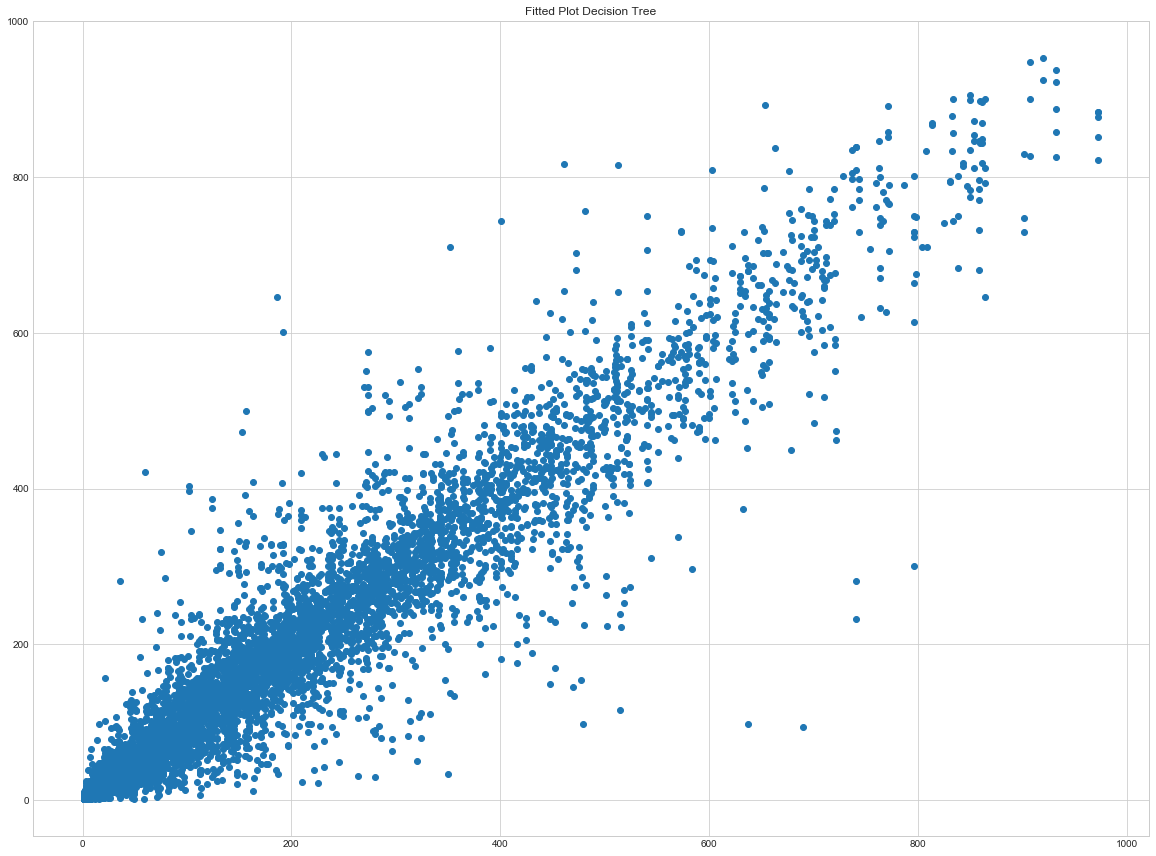

RMSLE: 0.426099445355
R^2: 0.90178313212
Root Mean Squared Error: 57.1325423152


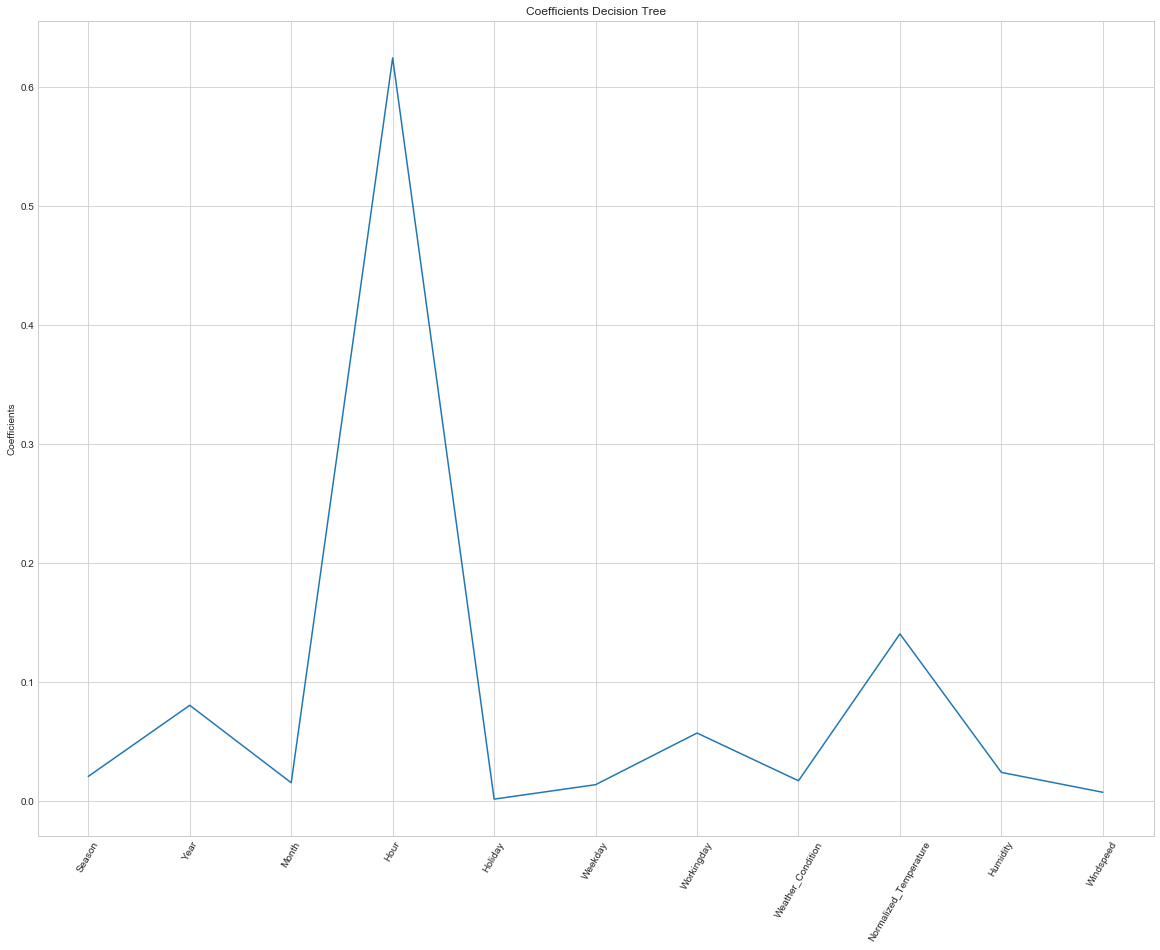

In [20]:
decisionTreeRegressor(df)

<h1>Decision Tree Regressor with Dummy Variables</h1>

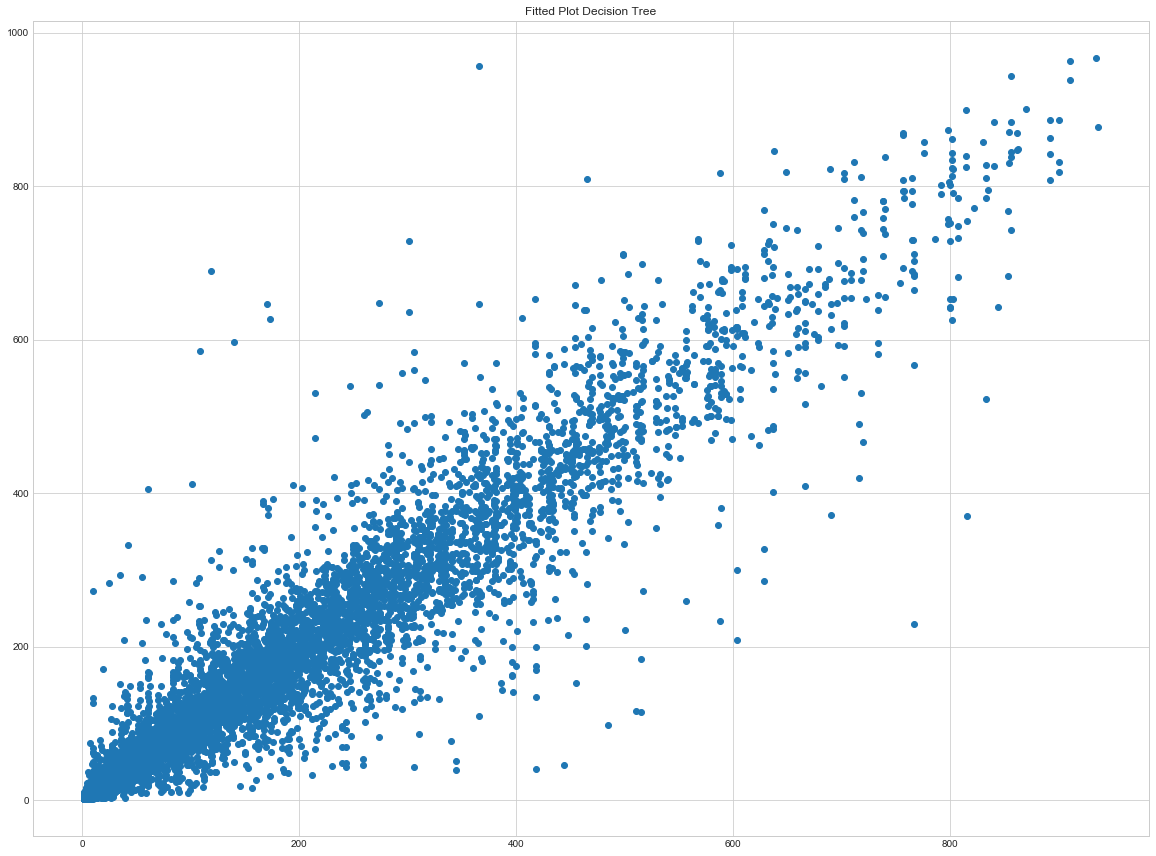

RMSLE: 0.422089786705
R^2: 0.894067272923
Root Mean Squared Error: 59.0145860458


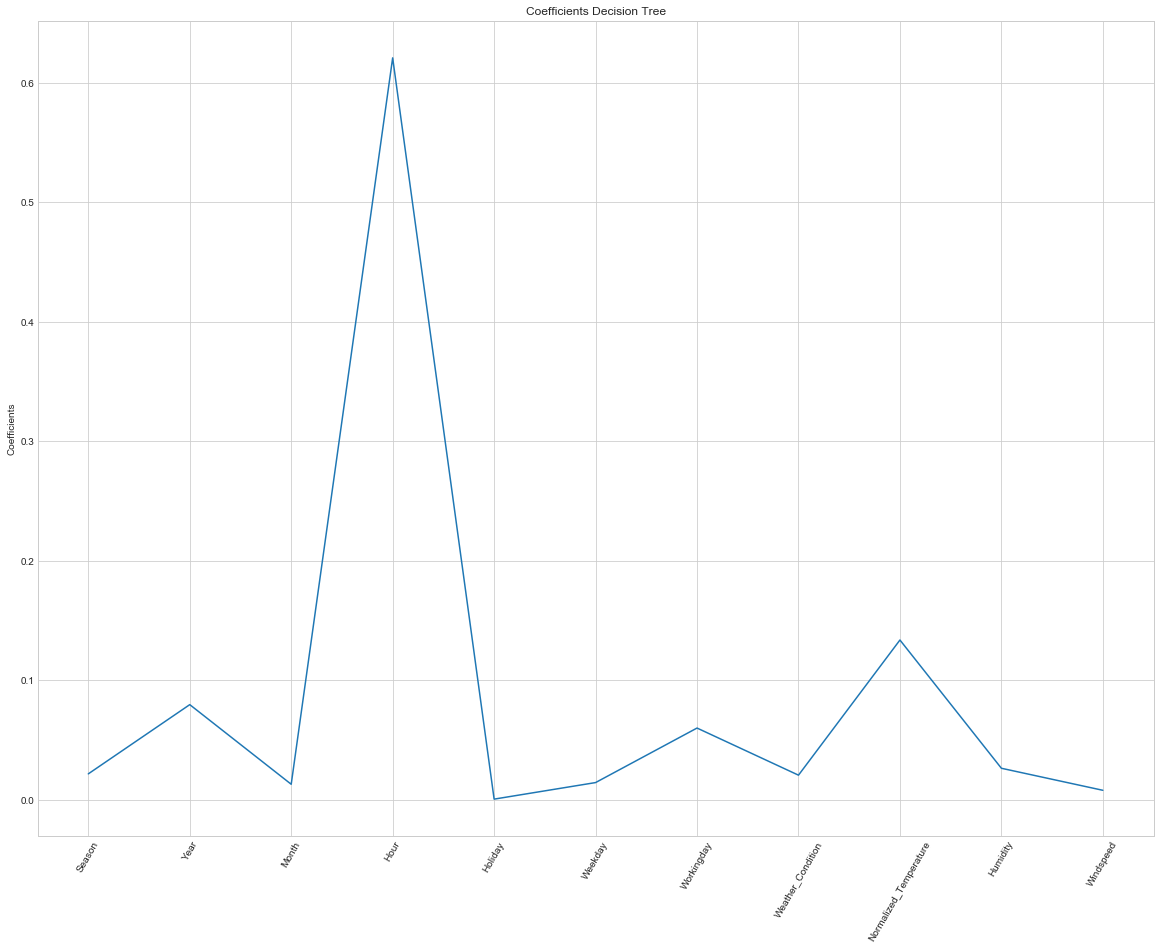

In [21]:
# with dummies
dum_df = pd.get_dummies(df, columns=["Weekday","Season","Weather_Condition"])
decisionTreeRegressor(df)

In [22]:
reg = DecisionTreeRegressor(max_depth=35)
crossValScore(reg,10)

Average 10-Fold CV Score: 0.643844355348


<h1>Random Forest - Randomized Search CV</h1>

In [23]:
def randomForestRegressionOptimizer(df):
    
    df = df.sample(frac=1)
    features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
    X = features.values
    y = np.log(df[labels]).values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4)
    
    
    # Number of trees in random forest
    n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]
    # Number of features to consider at every split
    max_features = ['auto']
    # Maximum number of levels in tree
    max_depth = [int(x) for x in np.linspace(1, 50, num = 11)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    regr = RandomForestRegressor()
    reg_random = RandomizedSearchCV(estimator = regr, param_distributions = random_grid, n_iter = 20, cv = 3, verbose=2, random_state=42, n_jobs = -1)
    
    reg_random.fit(X_train, y_train)
    
    pprint(reg_random.best_params_)
    best_random = reg_random.best_estimator_
    base_model = RandomForestRegressor(n_estimators = 50, random_state = 42)
    base_model.fit(X_train, y_train)
    
    print("R^2 Base : {}".format(base_model.score(X_test, y_test)))
    print("R^2 Randomized Search Cross Validation: {}".format(best_random.score(X_test, y_test)))


In [24]:
randomForestRegressionOptimizer(df)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=10, min_samples_split=10, max_features=auto, max_depth=45 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=10, min_samples_split=10, max_features=auto, max_depth=45 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=50, min_samples_split=2, max_features=auto, max_depth=10 
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=10, min_samples_split=10, max_features=auto, max_depth=45 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=50, min_samples_split=2, max_features=auto, max_depth=10 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=50, min_samples_split=2, max_features=auto, max_depth=10 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=10, min_samples_split=10, max_features=auto, max_depth=1 
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=10, min_samples_split=10, max_features=auto, max_depth=1 
[CV]  bootstrap=False, min_samples_

[CV] bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=2, max_features=auto, max_depth=None 
[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=60, min_samples_split=5, max_features=auto, max_depth=5, total=   1.0s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=60, min_samples_split=5, max_features=auto, max_depth=5 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=2, max_features=auto, max_depth=None, total=   2.2s
[CV] bootstrap=False, min_samples_leaf=2, n_estimators=60, min_samples_split=5, max_features=auto, max_depth=5 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=2, max_features=auto, max_depth=30, total=   2.2s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=60, min_samples_split=10, max_features=auto, max_depth=50 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=2, max_features=auto, max_depth=30, total=   2.3s
[CV] bootstrap=False, min_samples_l

[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.3s


[CV]  bootstrap=False, min_samples_leaf=2, n_estimators=60, min_samples_split=5, max_features=auto, max_depth=5, total=   1.0s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=60, min_samples_split=10, max_features=auto, max_depth=50 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=100, min_samples_split=5, max_features=auto, max_depth=40, total=   2.9s
[CV] bootstrap=True, min_samples_leaf=2, n_estimators=100, min_samples_split=5, max_features=auto, max_depth=40 
[CV]  bootstrap=True, min_samples_leaf=2, n_estimators=100, min_samples_split=5, max_features=auto, max_depth=40, total=   2.9s
[CV] bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=5, max_features=auto, max_depth=20 
[CV]  bootstrap=False, min_samples_leaf=4, n_estimators=60, min_samples_split=2, max_features=auto, max_depth=None, total=   2.2s
[CV] bootstrap=False, min_samples_leaf=1, n_estimators=50, min_samples_split=5, max_features=auto, max_depth=5 
[CV]  bootstrap=True, min_samples_le

[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   12.8s finished


{'bootstrap': True,
 'max_depth': 25,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 100}
R^2 Base : 0.942873371849
R^2 Randomized Search Cross Validation: 0.943207921188


<h1>Random Forest Best Model</h1>

In [25]:
def randomForestRegressor(df):
    
    df = df.sample(frac=1,random_state=1)
    features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
    X = features.values
    y = df[labels].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4,random_state=1)

    regr = RandomForestRegressor(bootstrap= True,max_depth=25,
     min_samples_leaf= 1,
     min_samples_split= 2,
     n_estimators = 100)
    regr.fit(X_train, y_train)
    
    # Save the model
    filename = '../../model/finalized_model.sav'
    pickle.dump(regr, open(filename, 'wb'))

    y_pred = regr.predict(X_test)
    
    print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test,y_pred))))
    print("R^2: {}".format(regr.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    
    feature_imp = regr.feature_importances_
    
    df_plt = features.columns
    _ = plt.plot(range(len(df_plt)),feature_imp)
    _ = plt.xticks(range(len(df_plt)),df_plt,rotation=60)
    _ = plt.title('Coefficients Decision Tree')
    _ = plt.ylabel('Coefficients')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    savefig('../../plot/img/random_forest_regression_demand.png', bbox_inches='tight')


RMSLE: 0.348745611546
R^2: 0.940947248526
Root Mean Squared Error: 44.4486646249


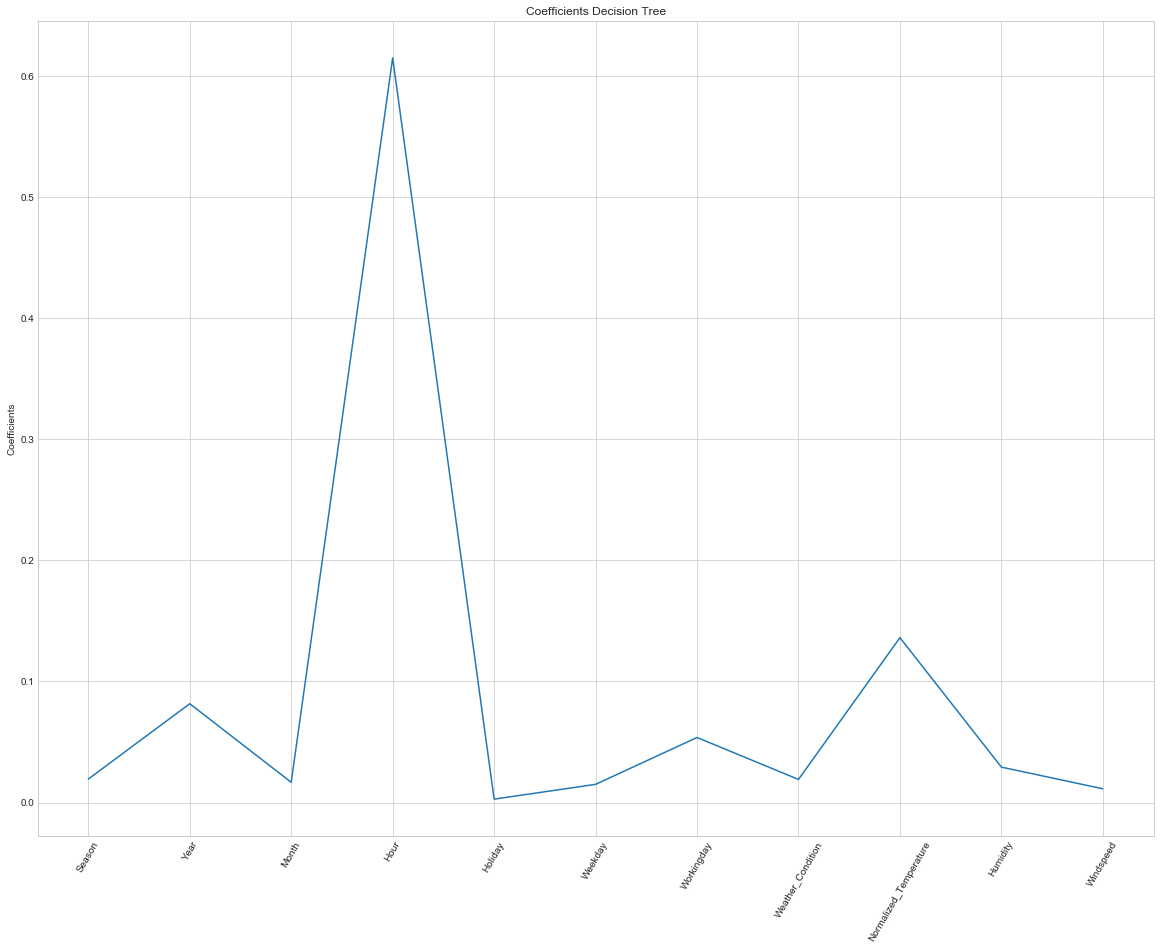

In [26]:
randomForestRegressor(df)

<h1>Random Forest With Dummy variables</h1>

RMSLE: 0.348480460483
R^2: 0.940867083979
Root Mean Squared Error: 44.4788240887


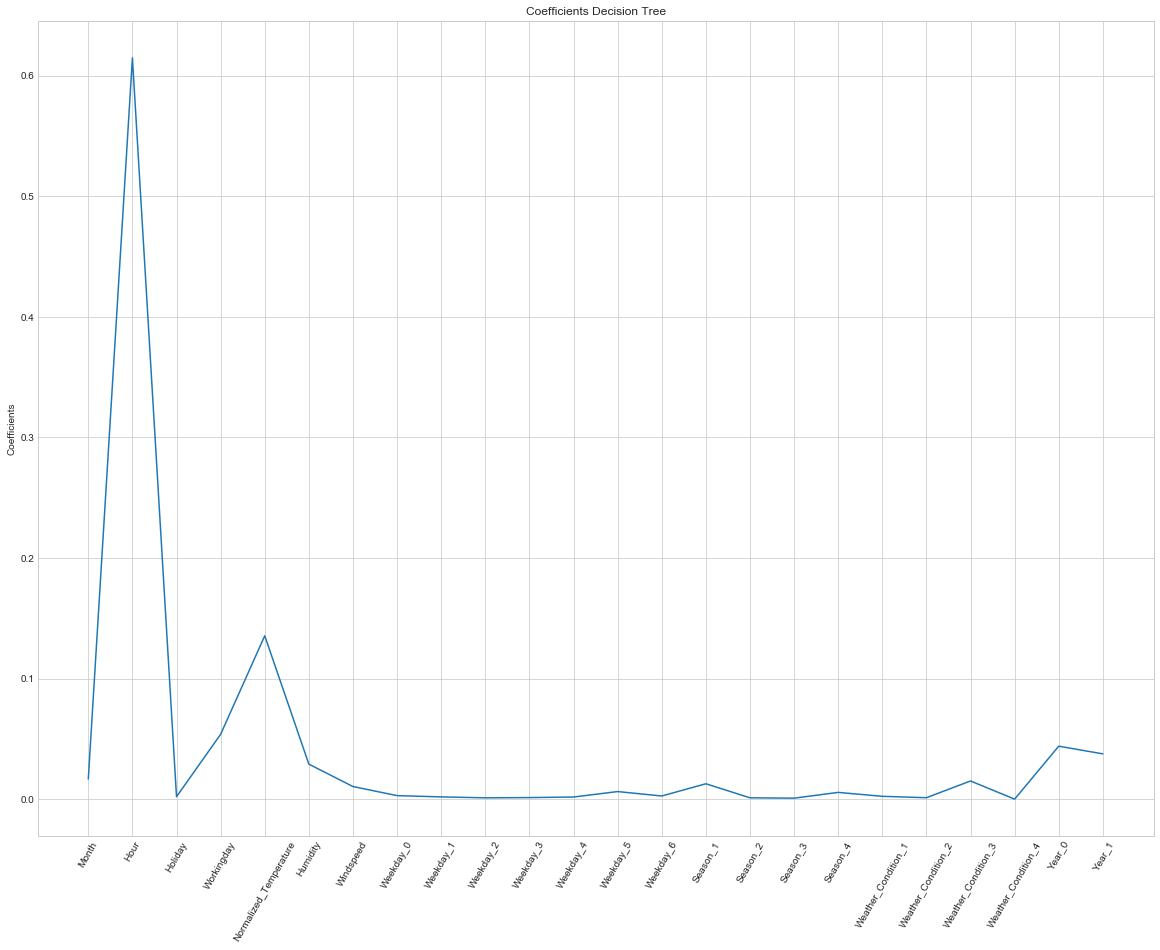

In [27]:
dum_df = pd.get_dummies(df, columns=["Weekday","Season","Weather_Condition","Year"])
randomForestRegressor(dum_df)

In [31]:
reg = RandomForestRegressor(bootstrap= True,max_depth=25,
     min_samples_leaf= 1,
     min_samples_split= 2,
     n_estimators = 100)
crossValScore(reg,10)

Average 10-Fold CV Score: 0.793490117207


<h1>Final Model - Random Forest</h1>

In [29]:
def loadRandomForestRegressor(df):
    
    df = df.sample(frac=1,random_state=1)
    features = df.drop(['Demand','Casual','Registered','Normalized_Feels_Temperture'],axis=1)
    X = features.values
    y = df[labels].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4,random_state=1)

    filename = '../../model/finalized_model.sav'
    loaded_model = pickle.load(open(filename, 'rb'))
    
    y_pred = loaded_model.predict(X_test)
    _ = plt.scatter(y_pred,y_test)
    _ = plt.title('Fitted Plot Random Forest')
    _ = plt.rcParams['figure.figsize'] = [20, 15]
    savefig('../../plot/img/randomforest_fitted_plot.png', bbox_inches='tight')
    plt.show()
    print("RMSLE: {}".format(np.sqrt(mean_squared_log_error(y_test,y_pred))))
    print("R^2: {}".format(loaded_model.score(X_test, y_test)))
    rmse = np.sqrt(mean_squared_error(y_test,y_pred))
    print("Root Mean Squared Error: {}".format(rmse))
    
    residuals = [y_test[i]-y_pred[i] for i in range(len(y_pred))]
    residuals = pd.DataFrame(residuals)
    # plot residuals
    residuals.plot()
    _ = plt.title('Residual Plot Random Forest')
    savefig('../../plot/img/random_forest_residual_plot.png', bbox_inches='tight')
    plt.show()
    
    #_ = plt.plot(y_test-y_pred)
    #_ = plt.rcParams['figure.figsize'] = [20, 15]
    #savefig('../../plot/img/random_forest_residual_plot.png', bbox_inches='tight')
    #plt.show()

<h1>Dummy Variables</h1>

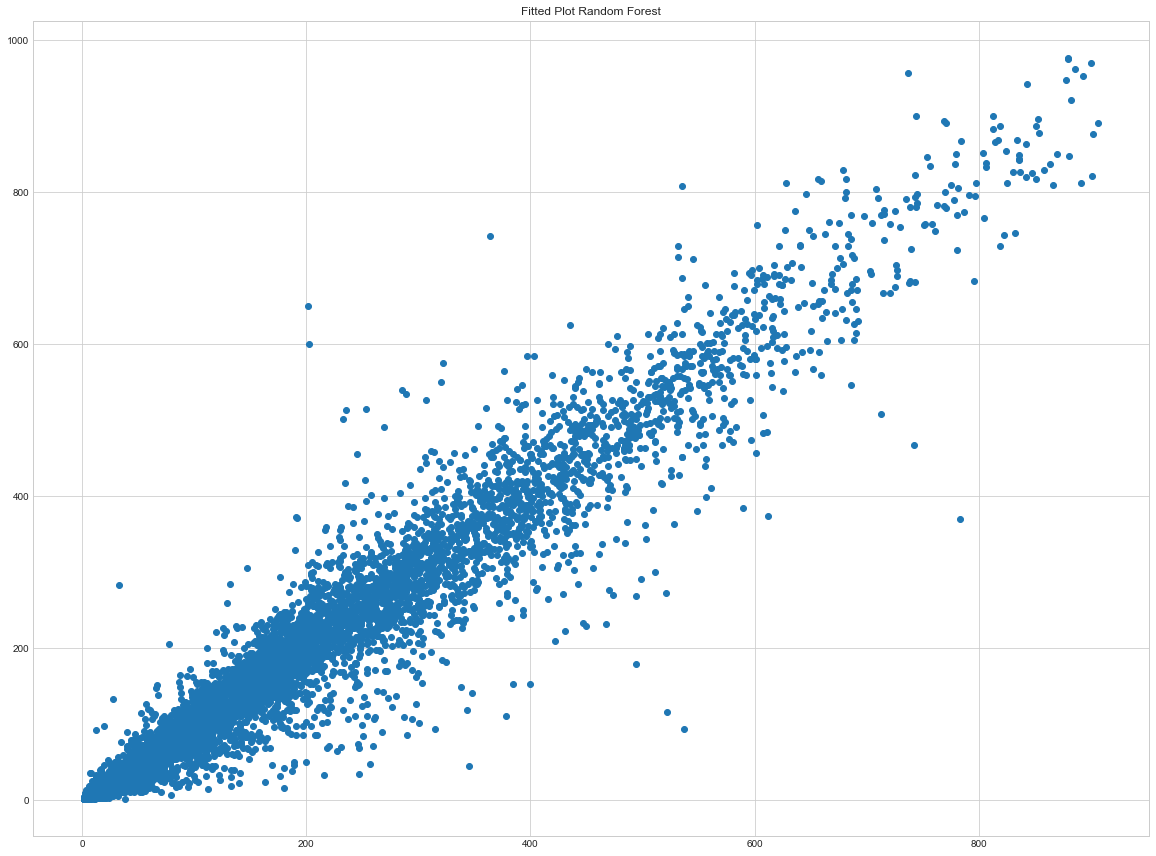

RMSLE: 0.348480460483
R^2: 0.940867083979
Root Mean Squared Error: 44.4788240887


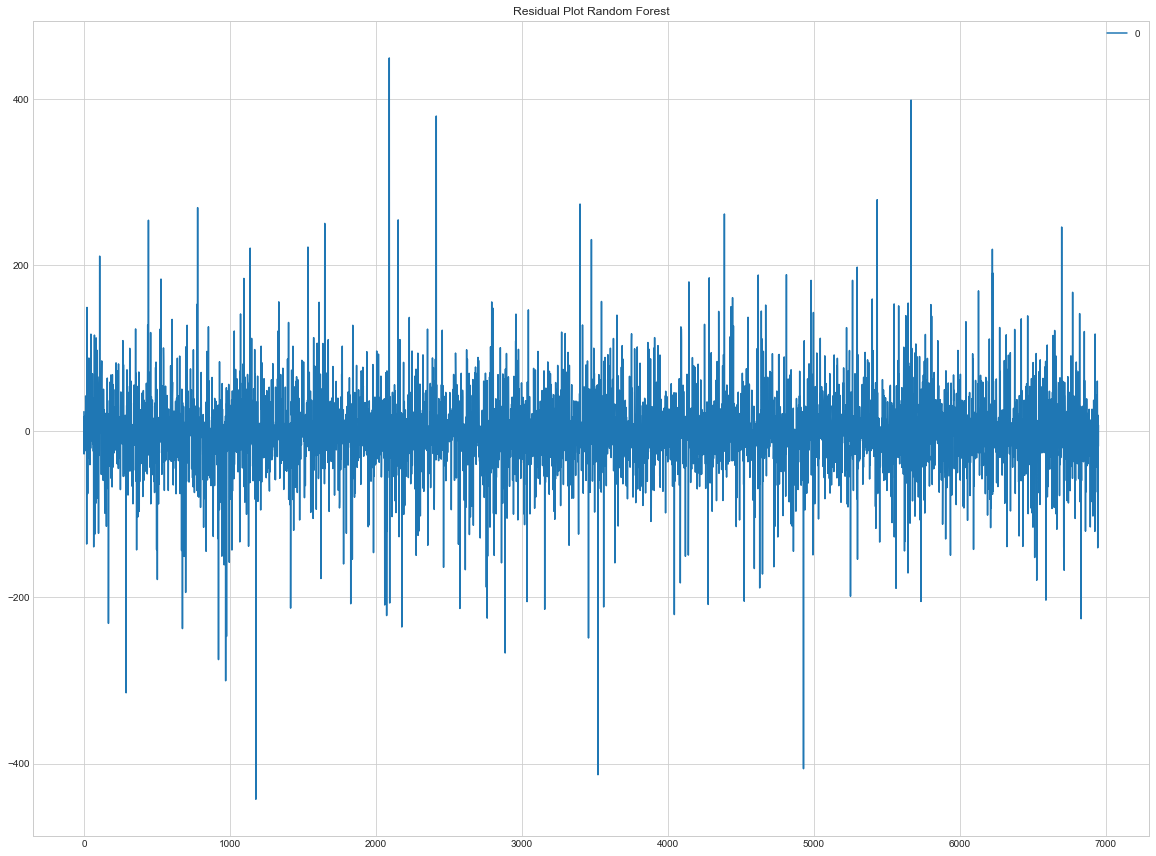

In [30]:
dum_df = pd.get_dummies(df, columns=["Weekday","Season","Weather_Condition","Year"])
loadRandomForestRegressor(dum_df)